In [1]:
import os
import sys

import cv2
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from skimage import measure
from sklearn.neighbors import NearestNeighbors

fontprops = fm.FontProperties(size=34)
from pathlib import Path


sns.set(font_scale=2)
%matplotlib inline
from sklearn.metrics.pairwise import paired_distances
from sklearn.preprocessing import MinMaxScaler

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from config import *

In [5]:
datasets = sorted([str(f) for f in data_raw.iterdir() if f.is_dir()])
datasets = [name.split("\\")[-1] for name in datasets]
print(datasets)

['DT1', 'DT2', 'DT3', 'DT4', 'DT5', 'DT6', 'NT1', 'NT2', 'NT3', 'NT4', 'NT5', 'NT6']


In [6]:
conditions = ["Disease"] * 6 + ["Healthy"] * 6

In [7]:
# datasets = ['DT1', 'DT2', 'DT3', 'NT1', 'NT2', 'NT3']
# conditions = ["Disease"] * 3 + ["Healthy"] * 3

# Get stats

In [8]:
df = pd.DataFrame()
df_exp = pd.DataFrame()
for n, dataset in enumerate(datasets):
    markers = []
    imgs = []
    masks = []

    for (dirpath, dirnames, filenames) in os.walk(data_raw / dataset):
        for name in sorted(filenames):
            if "tiff" in name and dataset in name:
                img = cv2.imread(
                    os.path.join(dirpath, name),
                    flags=(cv2.IMREAD_GRAYSCALE | cv2.IMREAD_ANYDEPTH),
                )
                imgs.append(img)
                markers.append(name.split("_")[1].split(".")[0])

    for (dirpath, dirnames, filenames) in os.walk(data_mask / dataset):
        for name in sorted(filenames):
            if "tiff" in name and dataset in name:
                img = cv2.imread(os.path.join(dirpath, name), 0)
                masks.append(img)

    # Read cell mask image
    for (dirpath, dirnames, filenames) in os.walk(data_cell_mask):
        for name in sorted(filenames):
            if "tiff" in name and dataset in name:
                cell_mask = np.array(Image.open(os.path.join(dirpath, name)))

    max_cell = len(np.unique(cell_mask))

    # Read mean intensity of marker in cell
    marker_area = {}
    marker_exp = {}
    for idx, marker in enumerate(markers):
        #         if marker in ['DNA1', 'DNA2', 'Histone3']:
        #             continue
        mask_marker = cv2.bitwise_and(cell_mask, cell_mask, mask=masks[idx])
        cell_count = len(np.unique(mask_marker)) / max_cell
        marker_area[marker] = [cell_count]
        prop = measure.regionprops_table(
            mask_marker, imgs[idx], properties=["area", "mean_intensity"]
        )
        marker_exp[marker] = [np.sum(prop["mean_intensity"] * prop["area"])]

    df_temp = pd.DataFrame.from_dict(marker_area)
    df_temp["ROI"] = dataset
    df = df.append(df_temp, ignore_index=True)

    df_temp = pd.DataFrame.from_dict(marker_exp)
    df_temp["ROI"] = dataset
    df_exp = df_exp.append(df_temp, ignore_index=True)

df = df.drop(columns=["CD44", "H3K9me3", "MHCII"])
df_exp = df_exp.drop(columns=["CD44", "H3K9me3", "MHCII"])

In [9]:
df.set_index("ROI", inplace=True)
df.head()


,CD20,CD3,CD4,CD45RO,CD68,CD8a,Col1,DNA1,DNA2,Ecadherin,FoxP3,GranzymeB,Histone3,Ki67,PD1,PDL1,Pankeratin,SMA,Vimentin
ROI,,,,,,,,,,,,,,,,,,,
DT1,0.552816,0.442460,0.457072,0.748698,0.367396,0.352918,0.084003,0.991790,0.993555,0.195904,0.011234,0.226847,0.927231,0.298557,0.634789,0.086011,0.085393,0.610223,0.561512
DT2,0.447063,0.357655,0.411101,0.912694,0.653410,0.300248,0.140375,0.968574,0.971982,0.126765,0.022861,0.277586,0.895233,0.139556,0.811889,0.143606,0.105475,0.091090,0.739078
DT3,0.286203,0.240380,0.301941,0.800970,0.451031,0.123835,0.154241,0.998485,0.999198,0.227690,0.078725,0.163687,0.680985,0.059743,0.001836,0.000428,0.166200,0.025933,0.523464
DT4,0.483644,0.547635,0.521451,0.815544,0.155954,0.188507,0.058790,0.995577,0.996267,0.339490,0.114272,0.034906,0.901067,0.200485,0.037383,0.013110,0.107832,0.703961,0.424588
DT5,0.604307,0.649146,0.537125,0.937858,0.517896,0.599319,0.287078,0.995924,0.997437,0.129547,0.116286,0.314184,0.955849,0.153919,0.874013,0.088956,0.018283,0.111281,0.375449


In [10]:
# df.drop(columns=['DNA1','DNA2'], inplace=True)

In [11]:
scaler = MinMaxScaler()
df_exp.set_index("ROI", inplace=True)
scaled_rows = scaler.fit_transform(df_exp.T).T
df_exp = pd.DataFrame(scaled_rows, index=df_exp.index, columns=df_exp.columns)
df_exp.head()

,CD20,CD3,CD4,CD45RO,CD68,CD8a,Col1,DNA1,DNA2,Ecadherin,FoxP3,GranzymeB,Histone3,Ki67,PD1,PDL1,Pankeratin,SMA,Vimentin
ROI,,,,,,,,,,,,,,,,,,,
DT1,0.170253,0.192611,0.196782,0.582347,0.147461,0.107323,0.087577,0.955387,1.0,0.146370,0.000000,0.122995,0.849058,0.062322,0.057196,0.000969,0.049472,0.169129,0.268222
DT2,0.227372,0.156521,0.144230,0.686481,0.361973,0.079492,0.087310,0.949906,1.0,0.115133,0.000000,0.139409,0.777921,0.052640,0.090644,0.009979,0.065060,0.037457,0.438080
DT3,0.167660,0.134254,0.121249,0.529960,0.238366,0.046991,0.103392,0.946838,1.0,0.153847,0.016752,0.094189,0.506628,0.023698,0.000232,0.000000,0.111296,0.008300,0.333991
DT4,0.235483,0.277518,0.240513,0.707859,0.067588,0.077740,0.040308,0.936618,1.0,0.328510,0.016656,0.021135,0.936848,0.069048,0.008195,0.000000,0.068638,0.294896,0.272957
DT5,0.197355,0.364889,0.287238,0.695368,0.128758,0.183521,0.091589,0.932131,1.0,0.038512,0.011343,0.056407,0.836116,0.027508,0.086143,0.000000,0.008374,0.020645,0.160423


# Visualization

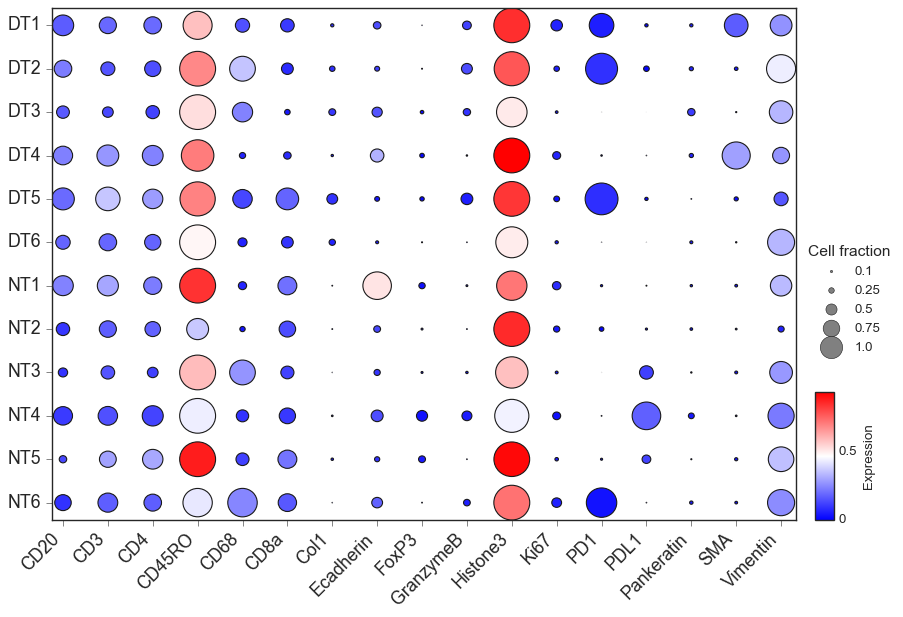

In [26]:
from matplotlib.collections import PatchCollection

plt.style.use("classic")
plt.style.use("seaborn-white")

xlabels = df.columns.tolist()
ylabels = df.index.tolist()
M = len(xlabels)
N = len(ylabels)

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = df.values
c = df_exp.values

# Get size and color
R = s / s.max(axis=1)[:, np.newaxis] / 2.5
circles = [plt.Circle((j, i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="bwr")

# Plot image
fig, ax = plt.subplots(figsize=(12, 8))
ax.add_collection(col)
ax.set(
    xticks=np.arange(M), yticks=np.arange(N), xticklabels=xlabels, yticklabels=ylabels
)
ax.set_xticks(np.arange(M + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(N + 1) - 0.5, minor=True)
ax.set_xticklabels(xlabels, rotation=45, ha="right")
ax.tick_params(which="major", length=5)
ax.tick_params(top=False, right=False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.invert_yaxis()

# Color legend
cbar = fig.colorbar(col, cax=fig.add_axes([0.92, 0.1, 0.02, 0.2]), ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(["0", "0.5", "1.0"])
cbar.set_label("Expression")

# Size legend
h = [
    ax.plot([], [], color="gray", marker="o", ms=i * 2, ls="", label=i / 10)[0]
    for i in [1, 2.5, 5, 7.5, 10]
]
leg = ax.legend(
    handles=h, loc="lower left", bbox_to_anchor=(1.0, 0.3, 0.02, 0.4), fontsize="medium"
)
leg.set_title("Cell fraction", prop={"size": 14})

plt.show()

In [93]:
df_subset = df.loc[["DT1", "DT2", "DT3", "NT1", "NT2", "NT3"]]
df_subset_exp = df_exp.loc[["DT1", "DT2", "DT3", "NT1", "NT2", "NT3"]]

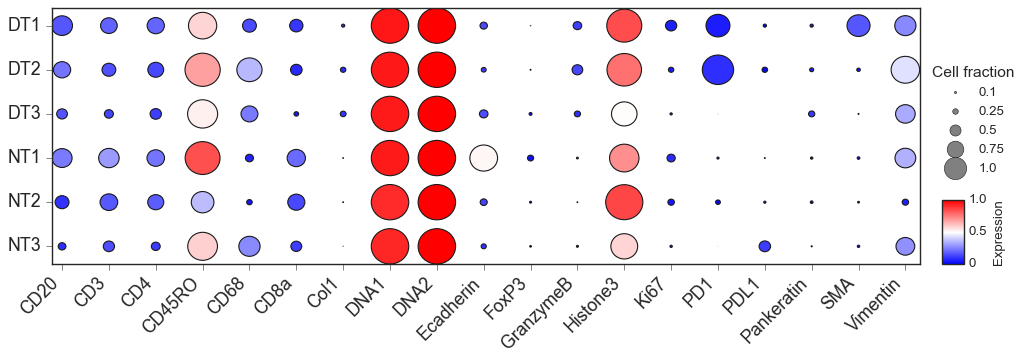

In [94]:
from matplotlib.collections import PatchCollection

plt.style.use("classic")
plt.style.use("seaborn-white")

xlabels = df_subset.columns.tolist()
ylabels = df_subset.index.tolist()
M = len(xlabels)
N = len(ylabels)

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = df_subset.values
c = df_subset_exp.values

# Get size and color
R = s / s.max(axis=1)[:, np.newaxis] / 2.5
circles = [plt.Circle((j, i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="bwr")

# Plot image
fig, ax = plt.subplots(figsize=(14, 4))
ax.add_collection(col)
ax.set(
    xticks=np.arange(M), yticks=np.arange(N), xticklabels=xlabels, yticklabels=ylabels
)
ax.set_xticks(np.arange(M + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(N + 1) - 0.5, minor=True)
ax.set_xticklabels(xlabels, rotation=45, ha="right")
ax.tick_params(which="major", length=5)
ax.tick_params(top=False, right=False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.invert_yaxis()

# Color legend
cbar = fig.colorbar(col, cax=fig.add_axes([0.92, 0.1, 0.02, 0.2]), ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(["0", "0.5", "1.0"])
cbar.set_label("Expression")

# Size legend
h = [
    ax.plot([], [], color="gray", marker="o", ms=i * 2, ls="", label=i / 10)[0]
    for i in [1, 2.5, 5, 7.5, 10]
]
leg = ax.legend(
    handles=h, loc="lower left", bbox_to_anchor=(1.0, 0.3, 0.02, 0.4), fontsize="medium"
)
leg.set_title("Cell fraction", prop={"size": 14})

plt.show()

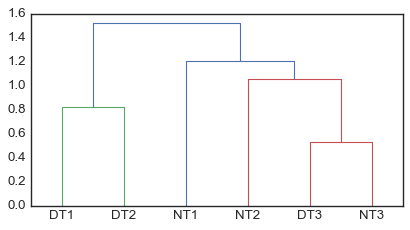

In [97]:
from scipy.cluster.hierarchy import dendrogram, linkage
scaled_rows = scaler.fit_transform(df_subset.T).T
df_subset = pd.DataFrame(scaled_rows, index=df_subset.index, columns=df_subset.columns)

df_subset_joined = df_subset.join(df_subset_exp, lsuffix="_area", rsuffix="_exp")

linked = linkage(df_subset_joined, "ward")

labelList = range(1, 11)

plt.figure(figsize=(6, 3))
dendrogram(
    linked,
    orientation="top",
    labels=df_subset_joined.index.tolist(),
    distance_sort="descending",
    show_leaf_counts=True,
)
plt.show()

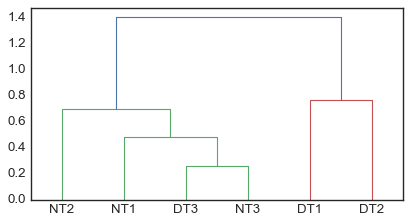

In [100]:
temp = df_subset_joined.iloc[:,[4, 11, 13, 14, 16, 17, 18, 23, 30, 32, 33, 35, 36, 37]]

linked = linkage(temp, "ward")

labelList = range(1, 11)

plt.figure(figsize=(6, 3))
dendrogram(
    linked,
    orientation="top",
    labels=df_subset_joined.index.tolist(),
    distance_sort="descending",
    show_leaf_counts=True,
)
plt.show()

# Spatial proximity dot plot

In [40]:
n = 5
neigh = NearestNeighbors(n_neighbors=n)

In [54]:
pairs = [
    ["GranzymeB", "CD68"],
    ["Pankeratin", "Ecadherin"],
    ["CD3", "CD4"],
    ["CD4", "CD20"],
    ["CD8a", "CD20"],
    ["Col1", "Pankeratin"],
    ["GranzymeB", "Vimentin"]
]

In [55]:
df = pd.DataFrame()
df_exp = pd.DataFrame()
for _, dataset in enumerate(datasets):
    print(dataset)
    imgs = []
    markers = []
    masks = []

    for (dirpath, dirnames, filenames) in os.walk(data_raw / dataset):
        for name in sorted(filenames):
            if "tiff" in name and dataset in name:
                img = cv2.imread(
                    os.path.join(dirpath, name),
                    flags=(cv2.IMREAD_GRAYSCALE | cv2.IMREAD_ANYDEPTH),
                )
                imgs.append(img)
                markers.append(name.split("_")[1].split(".")[0])

    for (dirpath, dirnames, filenames) in os.walk(data_mask / dataset):
        for name in sorted(filenames):
            if "tiff" in name and dataset in name:
                img = cv2.imread(os.path.join(dirpath, name), 0)
                masks.append(img)

    # Read cell mask image
    for (dirpath, dirnames, filenames) in os.walk(data_cell_mask):
        for name in sorted(filenames):
            if "tiff" in name and dataset in name:
                cell_mask = np.array(Image.open(os.path.join(dirpath, name)))

    cell_centroid_marker = {}

    for i, mask in enumerate(masks):
        res = cv2.bitwise_and(cell_mask, cell_mask, mask=mask)
        prop = measure.regionprops_table(res, properties=["centroid", "area"])
        # Read points location
        cell_centroid_marker[markers[i]] = np.vstack(
            (prop["centroid-0"], prop["centroid-1"])
        ).T

    distance_pair = {}
    marker_area = {}
    for i, pair in enumerate(pairs):
        name = "/".join(pair)
        X = cell_centroid_marker[pair[0]]
        neigh.fit(X)
        Y = cell_centroid_marker[pair[1]]

        # fit the NN
        neighbors = neigh.kneighbors(Y, return_distance=False)
        # Get the n neirest neighbors position per cell
        n_distance = X[neighbors]
        # Computes the distances between (X[0], Y[0]), (X[1], Y[1]) ....
        distance = paired_distances(Y, n_distance.mean(axis=1))
        distance_pair[name] = [distance.mean()]
        marker_area[name] = [np.count_nonzero(distance < 30)]

    df_temp = pd.DataFrame.from_dict(marker_area)
    df_temp["ROI"] = dataset
    df = df.append(df_temp, ignore_index=True)

    df_temp = pd.DataFrame.from_dict(distance_pair)
    df_temp["ROI"] = dataset
    df_exp = df_exp.append(df_temp, ignore_index=True)

DT1
DT2
DT3
NT1
NT2
NT3


In [56]:
df.set_index("ROI", inplace=True)
df.head()

,GranzymeB/CD68,Pankeratin/Ecadherin,CD3/CD4,CD4/CD20,CD8a/CD20,Col1/Pankeratin,GranzymeB/Vimentin
ROI,,,,,,,
DT1,11167,3098,20561,23804,21848,10,14024
DT2,18571,3002,17943,19647,18596,46,16196
DT3,13962,5162,14723,15439,12316,818,12338
NT1,4758,5139,22438,23424,23740,2,9182
NT2,2103,7136,23748,19898,20356,0,2390


In [57]:
scaler = MinMaxScaler()
df_exp.set_index("ROI", inplace=True)
scaled_rows = scaler.fit_transform(df_exp.T).T
df_exp = pd.DataFrame(scaled_rows, index=df_exp.index, columns=df_exp.columns)
df_exp.head()

,GranzymeB/CD68,Pankeratin/Ecadherin,CD3/CD4,CD4/CD20,CD8a/CD20,Col1/Pankeratin,GranzymeB/Vimentin
ROI,,,,,,,
DT1,0.046472,0.215084,0.000000,0.007357,0.020758,1.0,0.063114
DT2,0.080916,0.150304,0.002078,0.000000,0.012921,1.0,0.124135
DT3,0.349938,0.666184,0.058146,0.000000,0.141728,1.0,0.539744
NT1,0.112553,0.699644,0.000000,0.016001,0.014383,1.0,0.128862
NT2,0.140335,0.065548,0.000000,0.007139,0.005462,1.0,0.159341


In [58]:
df_subset = df.loc[["DT1", "DT2", "DT3", "NT1", "NT2", "NT3"]]
df_subset_exp = df_exp.loc[["DT1", "DT2", "DT3", "NT1", "NT2", "NT3"]]

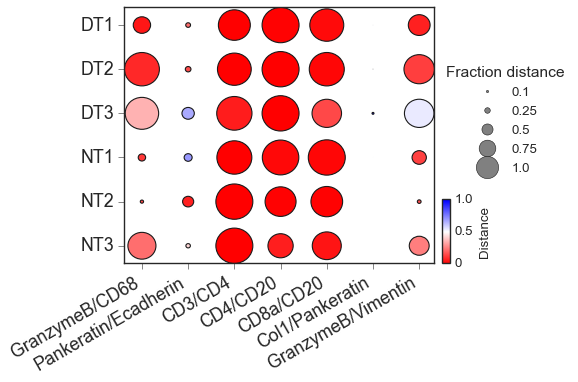

In [61]:
from matplotlib.collections import PatchCollection

plt.style.use("classic")
plt.style.use("seaborn-white")

xlabels = df_subset.columns.tolist()
ylabels = df_subset.index.tolist()
M = len(xlabels)
N = len(ylabels)

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = df_subset.values
c = df_subset_exp.values

# Get size and color
R = s / s.max(axis=1)[:, np.newaxis] / 2.5
circles = [plt.Circle((j, i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="bwr_r")

# Plot image
fig, ax = plt.subplots(figsize=(5, 4))
ax.add_collection(col)
ax.set(
    xticks=np.arange(M), yticks=np.arange(N), xticklabels=xlabels, yticklabels=ylabels
)
ax.set_xticks(np.arange(M + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(N + 1) - 0.5, minor=True)
ax.set_xticklabels(xlabels, rotation=30, ha="right")
ax.tick_params(which="major", length=5)
ax.tick_params(top=False, right=False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.invert_yaxis()

# Color legend
cbar = fig.colorbar(col, cax=fig.add_axes([0.92, 0.1, 0.02, 0.2]), ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(["0", "0.5", "1.0"])
cbar.set_label("Distance")

# Size legend
h = [
    ax.plot([], [], color="gray", marker="o", ms=i * 2, ls="", label=i / 10)[0]
    for i in [1, 2.5, 5, 7.5, 10]
]
leg = ax.legend(
    handles=h, loc="lower left", bbox_to_anchor=(1.0, 0.3, 0.02, 0.4), fontsize="medium"
)
leg.set_title("Fraction distance", prop={"size": 14})

plt.show()

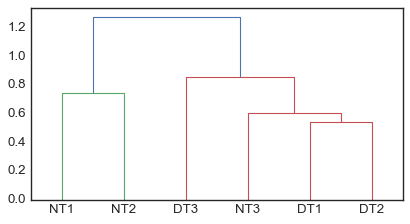

In [81]:
scaled_rows = scaler.fit_transform(df_subset.T).T
df_subset = pd.DataFrame(scaled_rows, index=df_subset.index, columns=df_subset.columns)

df_subset_joined = df_subset.join(df_subset_exp, lsuffix="_area", rsuffix="_exp")

linked = linkage(df_subset_joined, "ward")

plt.figure(figsize=(6, 3))
dendrogram(
    linked,
    orientation="top",
    labels=df_subset_joined.index.tolist(),
    distance_sort="descending",
    show_leaf_counts=True,
)
plt.show()

# ROI statistics

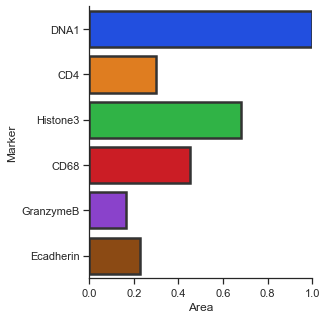

In [12]:
dataset = "DT3"
marker_list = ["DNA1", "CD4", "Histone3", "CD68", "GranzymeB", "Ecadherin"]

sns.set_style("ticks")
sns.set_context("notebook")
fig, ax = plt.subplots(figsize=(4, 5))
df_area = pd.DataFrame(df.loc[dataset, marker_list])
df_area.reset_index(inplace=True)
df_area.columns = ["Marker", "Area"]
ax = sns.barplot(
    x="Area", y="Marker", data=df_area, linewidth=2.5, edgecolor=".2", palette="bright"
)
ax.set_xlim(0, 1.0)
sns.despine()

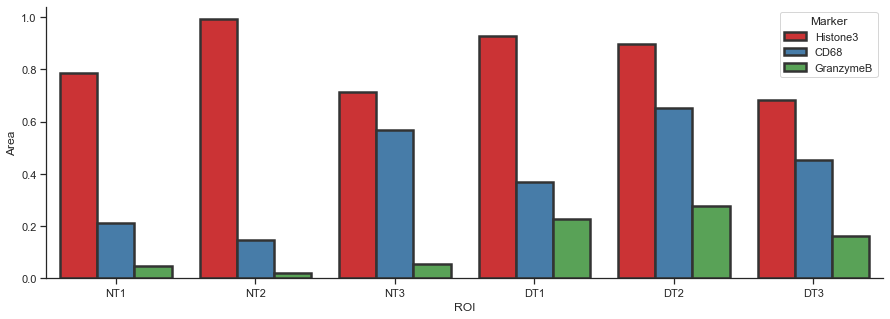

In [13]:
datasets = ["NT1", "NT2", "NT3", "DT1", "DT2", "DT3"]
marker_list = ["Histone3", "CD68", "GranzymeB"]

sns.set_style("ticks")
sns.set_context("notebook")
df_area = pd.DataFrame(df.loc[datasets, marker_list])
df_area.reset_index(inplace=True)
df_area = df_area.melt(id_vars=["ROI"], var_name="Marker", value_name="Area")
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.barplot(
    x="ROI",
    y="Area",
    hue="Marker",
    data=df_area,
    linewidth=2.5,
    edgecolor=".2",
    palette="Set1",
)
sns.despine()

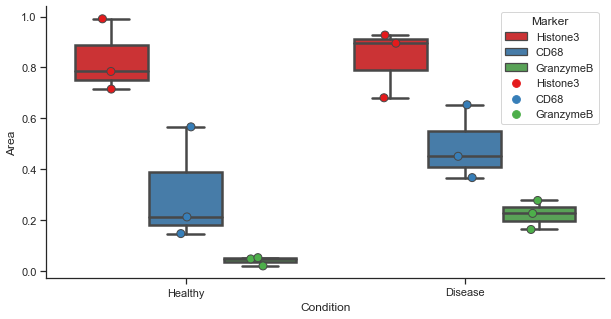

In [18]:
datasets = ["NT1", "NT2", "NT3", "DT1", "DT2", "DT3"]
marker_list = ["Histone3", "CD68", "GranzymeB"]
condition = ["Healthy"] * 3 + ["Disease"] * 3

sns.set_style("ticks")
sns.set_context("notebook")
df_area = pd.DataFrame(df.loc[datasets, marker_list])
df_area["Condition"] = condition
df_area = df_area.melt(id_vars=["Condition"], var_name="Marker", value_name="Area")

fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.boxplot(
    x="Condition", y="Area", hue="Marker", linewidth=2.5, data=df_area, palette="Set1"
)
ax2 = sns.stripplot(x="Condition", y="Area", hue="Marker", data=df_area,
              size=8, color=".3", palette="Set1", linewidth=1, dodge=True)
sns.despine()